In [33]:
# === A) Imports & Style ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [34]:
# === B) Load Data ===
CSV = "/content/survey_results_public.csv" # CHANGE THIS
df_raw = pd.read_csv(CSV, low_memory=False)
print("✅ Loaded:", CSV, "| shape:", df_raw.shape)
display(df_raw.head(3))

# Detect salary column across versions
if "ConvertedCompYearly" in df_raw.columns:
    salary_col = "ConvertedCompYearly"
elif "CompTotal" in df_raw.columns:
    salary_col = "CompTotal"
else:
    raise KeyError("Salary column not found. Expected 'ConvertedCompYearly' or 'CompTotal'.")

print("Using salary column:", salary_col)

✅ Loaded: /content/survey_results_public.csv | shape: (65437, 114)


,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,TechDoc,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,BuildvsBuy,TechEndorse,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,DatabaseAdmired,PlatformHaveWorkedWith,PlatformWantToWorkWith,PlatformAdmired,WebframeHaveWorkedWith,WebframeWantToWorkWith,WebframeAdmired,EmbeddedHaveWorkedWith,EmbeddedWantToWorkWith,EmbeddedAdmired,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,MiscTechAdmired,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,ToolsTechAdmired,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,NEWCollabToolsAdmired,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackAsyncAdmired,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,OfficeStackSyncAdmired,AISearchDevHaveWorkedWith,AISearchDevWantToWorkWith,AISearchDevAdmired,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOHow,SOComm,AISelect,AISent,AIBen,AIAcc,AIComplex,AIToolCurrently Using,AIToolInterested in Using,AIToolNot interested in Using,AINextMuch more integrated,AINextNo change,AINextMore integrated,AINextLess integrated,AINextMuch less integrated,AIThreat,AIEthics,AIChallenges,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Knowledge_9,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Frustration,ProfessionalTech,ProfessionalCloud,ProfessionalQuestion,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States of America,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have never visited Stack Overflow or the Sta...,NaN,NaN,NaN,NaN,NaN,Yes,Very favorable,Increase productivity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,API document(s) and/or SDK document(s);User gu...,20,17,"Developer, full-stack",NaN,NaN,NaN,NaN,NaN,United Kingdom of Great Britain and Northern I...,NaN,NaN,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Dynamodb;MongoDB;PostgreSQL,PostgreSQL,PostgreSQL,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Amazon Web Services (AWS);Heroku;Netlify,Express;Next.js;Node.js;React,Express;Htmx;Node.js;React;Remix,Express;Node.js;React,NaN,NaN,NaN,NaN,NaN,NaN,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,PyCharm;Visual Studio Code;WebStorm,MacOS;Windows,MacOS,NaN,NaN,NaN,Microsoft Teams;Slack,Slack,Slack,NaN,NaN,NaN,Stack Overflow for Teams (private knowledge sh...,Multiple times per day,Yes,Multiple times per day,Quickly finding code solutions;Finding reliabl...,"Yes, definitely","No, and I don't plan to",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Individual contributor,17.0,Agree,Disagree,Agree,Agree,Agree,Neither agree nor disa

Using salary column: ConvertedCompYearly


In [36]:
# === C) Clean / Prepare Base Data ===

# Make salary numeric, drop invalid/negatives
salary = pd.to_numeric(df_raw[salary_col], errors="coerce")
df = df_raw.copy()
df["Salary"] = salary
df = df[df["Salary"].notna() & (df["Salary"] > 0)]

# Trim extreme outliers by quantiles (keeps data even if currency varies)
q01, q99 = df["Salary"].quantile([0.01, 0.99])
df = df[(df["Salary"] >= q01) & (df["Salary"] <= q99)]

# Keep a small, robust set of columns if present
keep_cols = [c for c in ["Country", "EdLevel", "YearsCodePro", "Employment", "DevType", "JobSat"] if c in df.columns]
df = df[keep_cols + ["Salary"]].copy()

# YearsCodePro -> numeric
if "YearsCodePro" in df.columns:
    def clean_years(x):
        if pd.isna(x): return np.nan
        s = str(x).strip().lower()
        if s.startswith("less than"): return 0.5
        if s.startswith("more than 50"): return 51.0
        m = re.search(r"\d+(\.\d+)?", s)
        return float(m.group()) if m else np.nan
    df["YearsCodePro"] = df["YearsCodePro"].apply(clean_years)

# EdLevel buckets (simple)
if "EdLevel" in df.columns:
    def clean_ed(x):
        s = str(x)
        if "Bachelor" in s: return "Bachelors"
        if "Master"   in s: return "Masters"
        if "Professional" in s or "Doctoral" in s: return "PostGrad"
        return "Other"
    df["EdLevel"] = df["EdLevel"].apply(clean_ed)

# JobSat -> ordinal (optional; OK if NaN)
if "JobSat" in df.columns:
    job_sat_map = {
        "Very satisfied": 4,
        "Slightly satisfied": 3,
        "Neither satisfied nor dissatisfied": 2,
        "Slightly dissatisfied": 1,
        "Very dissatisfied": 0
    }
    df["JobSatNum"] = df["JobSat"].map(job_sat_map)

print("Rows after cleaning:", len(df))

Rows after cleaning: 22965


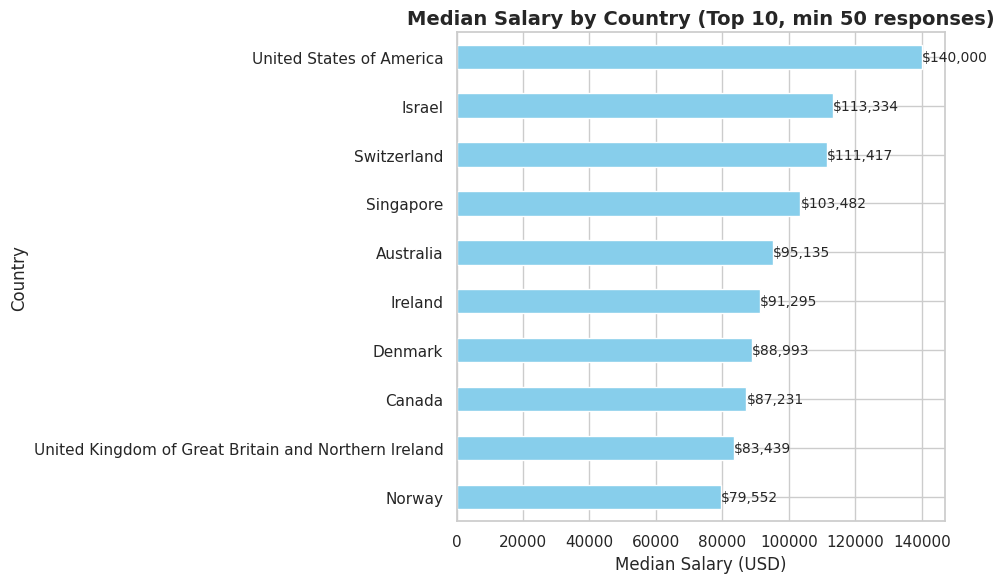

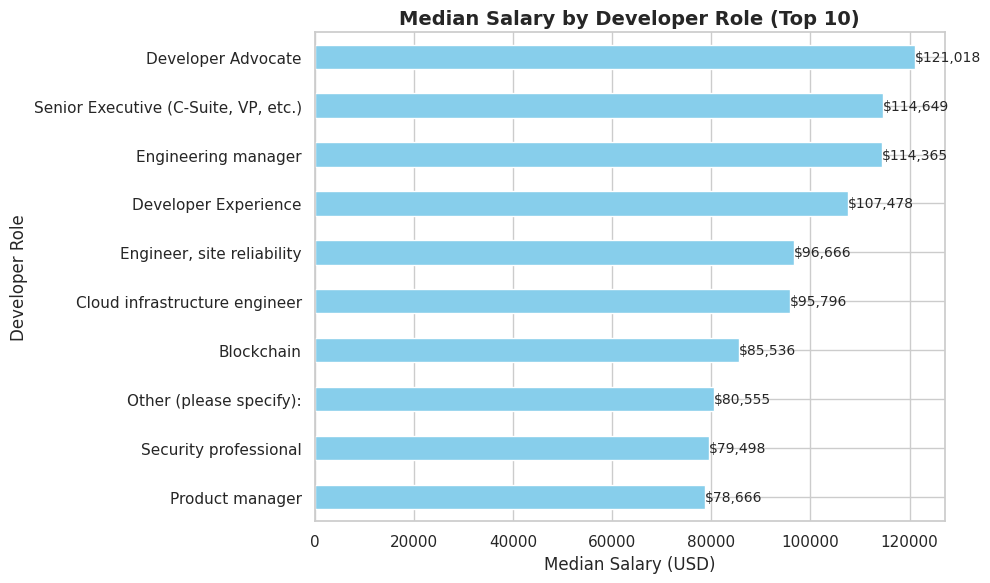

In [38]:
# === Median Salary by Country (Top 10, min 50 responses) ===
plt.figure(figsize=(10,6))
ms.sort_values().plot(kind="barh", color="skyblue")
for i, v in enumerate(ms.sort_values()):
    plt.text(v, i, f"${v:,.0f}", va="center", ha="left", fontsize=10)
plt.title("Median Salary by Country (Top 10, min 50 responses)", fontsize=14, weight="bold")
plt.xlabel("Median Salary (USD)", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.tight_layout(); plt.show()

# === Median Salary by Developer Role (Top 10) ===
plt.figure(figsize=(10,6))
role_medians.sort_values().plot(kind="barh", color="skyblue")
for i, v in enumerate(role_medians.sort_values()):
    plt.text(v, i, f"${v:,.0f}", va="center", ha="left", fontsize=10)
plt.title("Median Salary by Developer Role (Top 10)", fontsize=14, weight="bold")
plt.xlabel("Median Salary (USD)", fontsize=12)
plt.ylabel("Developer Role", fontsize=12)
plt.tight_layout(); plt.show()

In [39]:
# === E) Feature Engineering for ML ===
# Target
y = df["Salary"].astype(float)

# Build features: use what exists among these
base_cat = [c for c in ["Country", "EdLevel", "Employment"] if c in df.columns]
base_num = [c for c in ["YearsCodePro", "JobSatNum"] if c in df.columns]

# DevType is multi-label; turn it into top-k binary flags
X = df[base_cat + base_num].copy()

if "DevType" in df.columns:
    roles = (df.dropna(subset=["DevType"])
               .assign(DevType=df["DevType"].str.split(";"))
               .explode("DevType"))
    top_roles = roles["DevType"].value_counts().head(8).index  # top 8 roles
    for r in top_roles:
        X[f"role_{r}"] = df["DevType"].fillna("").str.contains(r, regex=False).astype(int)

print("Feature columns:", list(X.columns))
print("X shape:", X.shape, "| y:", y.shape)

Feature columns: ['Country', 'EdLevel', 'Employment', 'YearsCodePro', 'JobSatNum', 'role_Developer, full-stack', 'role_Developer, back-end', 'role_Developer, front-end', 'role_Developer, desktop or enterprise applications', 'role_Developer, mobile', 'role_Developer, embedded applications or devices', 'role_Other (please specify):', 'role_Data engineer']
X shape: (22965, 13) | y: (22965,)


In [40]:
X = X.loc[:, X.notna().any(axis=0)]

# --- 1) Train / test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 2) Feature lists (skip all-NaN already handled) ---
numeric_features = [c for c in X.columns if X[c].dtype.kind in "fc"]
categorical_features = [c for c in X.columns if c not in numeric_features]

# --- 3) Transformers ---
numeric_transformer = SimpleImputer(strategy="median")

# Use 'sparse=False' for maximum sklearn compatibility (older versions use this arg)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) if len(categorical_features) else "drop"

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# --- 4) Linear Regression pipeline ---
lr_model = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearRegression())
])
lr_model.fit(X_train, y_train)

# --- 5) Predictions & metrics ---
pred_lr = lr_model.predict(X_test)
mae_lr = mean_absolute_error(y_test, pred_lr)
r2_lr  = r2_score(y_test, pred_lr)

# Version-agnostic RMSE (manual sqrt of MSE; avoids 'squared=' kw)
mse_lr = mean_squared_error(y_test, pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(f"Linear Regression → MAE: {mae_lr:,.0f} | RMSE: {rmse_lr:,.0f} | R²: {r2_lr:.3f}")

Linear Regression → MAE: 27,881 | RMSE: 41,439 | R²: 0.544


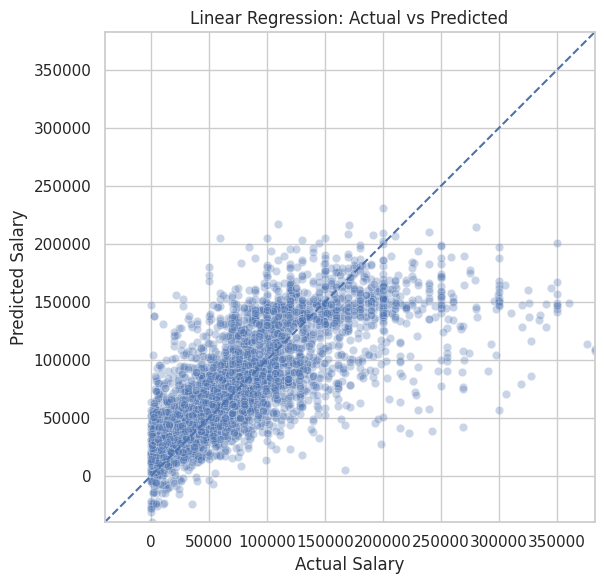

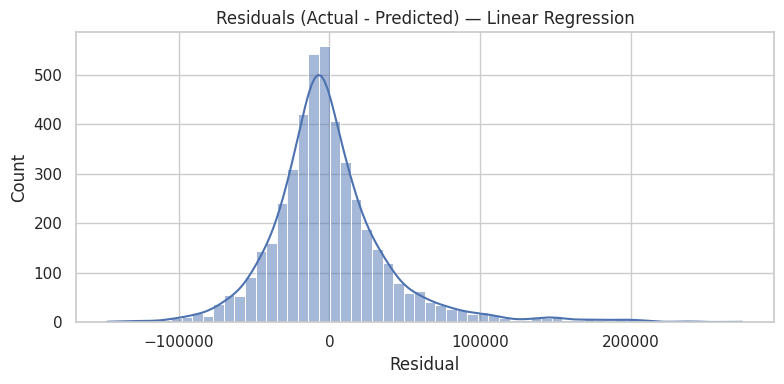

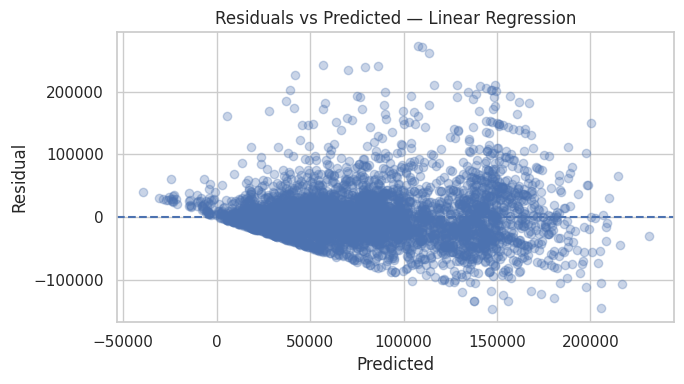

In [41]:
# 1) Linear Regression: Actual vs Predicted
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=pred_lr, alpha=0.3)
lims = [min(y_test.min(), pred_lr.min()), max(y_test.max(), pred_lr.max())]
plt.plot(lims, lims, ls="--")
plt.xlim(lims); plt.ylim(lims)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("Actual Salary"); plt.ylabel("Predicted Salary")
plt.title("Linear Regression: Actual vs Predicted")
plt.tight_layout(); plt.show()

# 2) Residuals distribution
resid = y_test - pred_lr
plt.figure(figsize=(8,4))
sns.histplot(resid, bins=60, kde=True)
plt.title("Residuals (Actual - Predicted) — Linear Regression")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# 3) Residuals vs Predicted
plt.figure(figsize=(7,4))
plt.scatter(pred_lr, resid, alpha=0.3)
plt.axhline(0, ls="--")
plt.xlabel("Predicted"); plt.ylabel("Residual")
plt.title("Residuals vs Predicted — Linear Regression")
plt.tight_layout(); plt.show()